## On plot les courbes Cl

In [1]:
import numpy as np
import torch 
from model import PINNs
import pandas as pd
from utils import charge_data
import json
import matplotlib.pyplot as plt
from plot_results import  plot_loss_decompose, plot_points, plot_loss
from model import PINNs
from utils import charge_data
import json
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
import numpy as np
import time as time
import pandas as pd
from geometry import RectangleWithoutCylinder

In [2]:
folder_name = "1_try_surrogate"
epoch = "epoch640"

In [3]:
param_adim = {"V": 1.0, "L": 0.025, "rho": 1.2}

In [4]:
with open("results/" + folder_name + "/hyper_param.json", "r") as file:
    hyper_param = json.load(file)
model = PINNs(hyper_param)
checkpoint = torch.load(
    "results/" + folder_name + "/" + epoch + "/" + "model_weights.pth",
    map_location=torch.device("cpu"),
)
model.load_state_dict(checkpoint["model_state_dict"])


/tmp/ipykernel_4082/3229211159.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


<All keys matched successfully>

In [5]:
with open('results/'+folder_name+'/mean_std.json') as file: 
    mean_std = json.load(file)

In [6]:
def true_cl(num, case, time_init, time_max):
    """
    Args:
        num (int): Le numéro du modèle
        case (int): Le numéro du case
        time_init (float): le temps initial 
        time_max (float): le temps max


    Returns:
        time (np.array):  les valeurs de temps
        cl (np.array): la valeur de cl à ces temps
    """
    df = pd.read_csv(f'results_Cl/model_{num}_case_{case}/Cl.csv', index_col=False)
    df_modified = df[((df.iloc[:, 2] > time_init) & (df.iloc[:, 2] < time_max))]
    time = df_modified.iloc[:, 2].to_numpy()
    cl = df_modified.iloc[:, 1].to_numpy()
    return time, cl


On a pour la force de portance : 

$
\overrightarrow{F_p}=-\int_{\theta=0}^{2\pi}(P(\theta)sin(\theta)rd\theta) \overrightarrow{u_y}
$

In [7]:
def P(theta, t, ya0, w0, model, param_adim, mean_std, r = 0.025 / 2):
    """
    Args:
        theta (torch.tensor): les theta où on veut calculer
        t_ad (torch.tensor): Les temps où on veut la pression en theta
        ya0 (float) : la valeur d'amplitude pour estimer notre pression
        model (torch.model): le NN qui prédit 
        param_adim (dict): dictionnaire des param d'adim
        mean_std (dict): donne de quoi faire la normalisation Z
        r (float): le rayon du cylindre

    Returns:
        P (torch.tensor):  les valeurs de pression sur le cylindre
    """
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    x_ad = ((x / param_adim['L']) - mean_std['x_mean'])/mean_std['x_std']
    y_ad = ((y / param_adim['L']) - mean_std['y_mean'])/mean_std['y_std']
    t_ad = ((t / (param_adim['L']/param_adim['V'])) - mean_std['t_mean']) / mean_std['t_std']
    ya0_ad = torch.ones_like(x_ad) * ((ya0 / param_adim['L']) - mean_std['ya0_mean']) / mean_std['ya0_std']
    w0_ad = torch.ones_like(x_ad) * ((w0 / (param_adim['V']/param_adim['L'])) - mean_std['w0_mean']) / mean_std['w0_std']
    X = torch.stack((x_ad, y_ad, t_ad, ya0_ad, w0_ad), dim=1)
    P_adim = model(X)[:, 2]
    P = ((P_adim * mean_std['p_std'] + mean_std['p_mean']))*((param_adim['V']**2)*param_adim['rho'])
    return P

In [8]:
def predict_cl(t, ya0, w0,  model, param_adim, mean_std, r=0.025 / 2, nb_disc_theta=500):
    """
    Args:
        t_ad (torch.tensor): Les temps où on veut Cl
        ya0 (float) : la valeur d'amplitude pour estimer notre Cl
        model (torch.model): le NN qui prédit 
        param_adim (dict): dictionnaire des param d'adim
        mean_std (dict): donne de quoi faire la normalisation Z
        r (float): le rayon du cylindre
        nb_disc_theta(int): sur combien de theta on discrétise

    Returns:
        Cl (torch.float):  les valeurs de pression sur le cylindre
    """
    time_repeat = torch.repeat_interleave(t, repeats=nb_disc_theta)
    d_theta = 2 * torch.pi / nb_disc_theta
    theta_int = torch.linspace(0, 2*torch.pi, nb_disc_theta)
    theta_tot = theta_int.repeat(t.shape[0])
    pressure_tot = P(theta_tot, time_repeat, ya0, w0, model, param_adim, mean_std, r = 0.025 / 2).reshape(t.shape[0], nb_disc_theta) # (t.shape, nb_disc_theta)
    in_sum = pressure_tot * torch.sin(theta_int) * r * d_theta
    portance = - torch.sum(in_sum, dim=1)
    return portance / (0.5 * param_adim['rho'] * param_adim['V']**2 * 2 * r)

In [9]:
ya0_L = [
    0.001875,
    0.003125,
    0.004375,
    0.005625,
    0.008125,
    0.010625,
    0.001875,
    0.003125,
    0.004375,
    0.005625,
    0.008125,
    0.010625,
]
H_L=[
    230.67,
    230.67,
    230.67,
    230.67,
    230.67,
    230.67,
    261.39,
    261.39,
    261.39,
    261.39,
    261.39,
    261.39,   
]
num = [
    10, 
    11, 
    12, 
    13,
    15, 
    17,
    10, 
    11, 
    12, 
    13,
    15, 
    17,
]

case = [
    2,
    2,
    2,
    2,
    2,
    2,
    1,
    1,
    1,
    1,
    1,
    1,
]

files = [f'data_john_{num[k]}_case_{case[k]}.csv' for k in range(len(num))]

In [10]:
f = np.min(0.5 * (np.array(H_L) / hyper_param["m"]) ** 0.5)

In [11]:

t_max = hyper_param['t_min'] + 1 / f 
t = torch.linspace(hyper_param['t_min'], t_max, 1000)



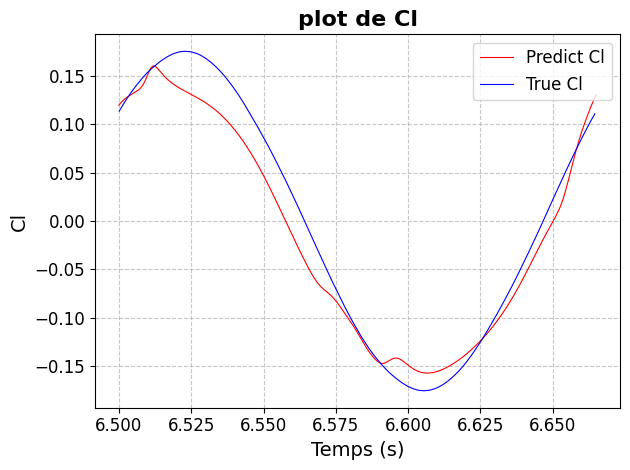

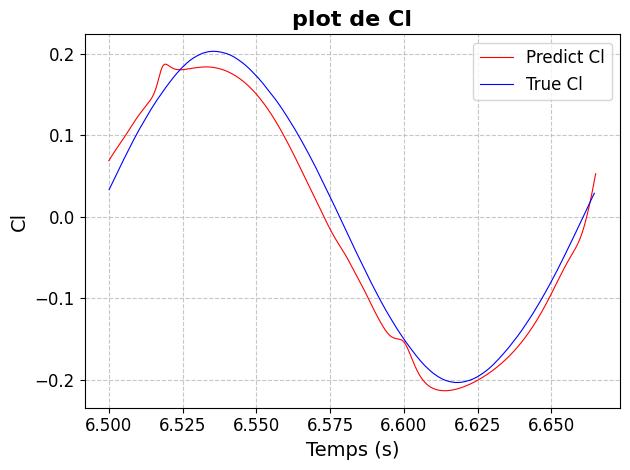

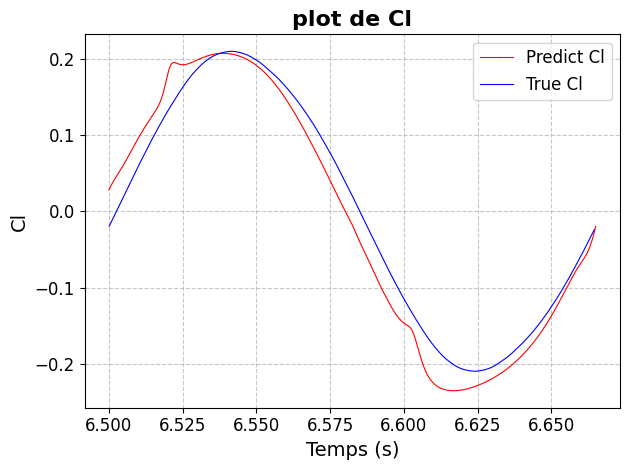

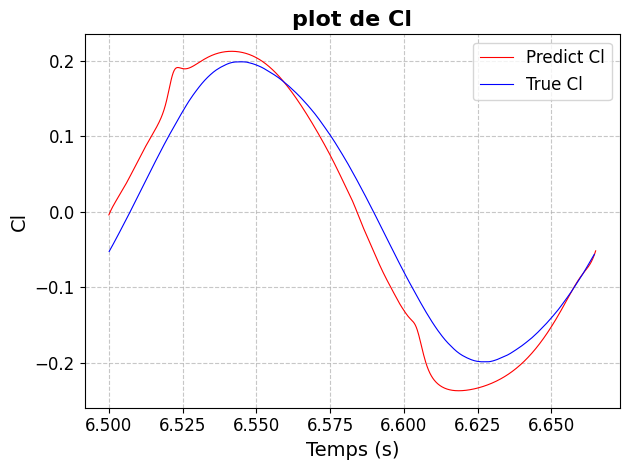

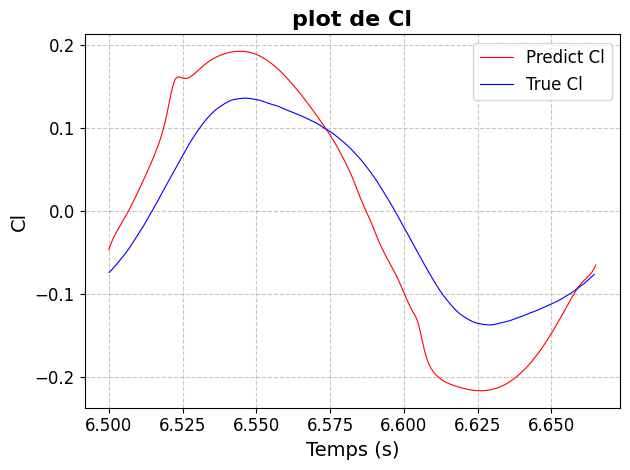

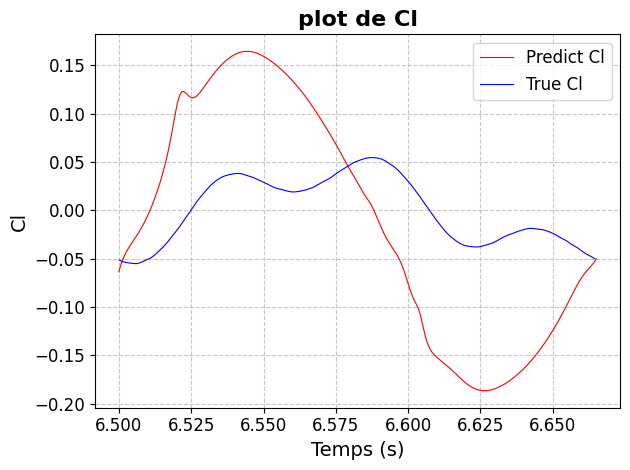

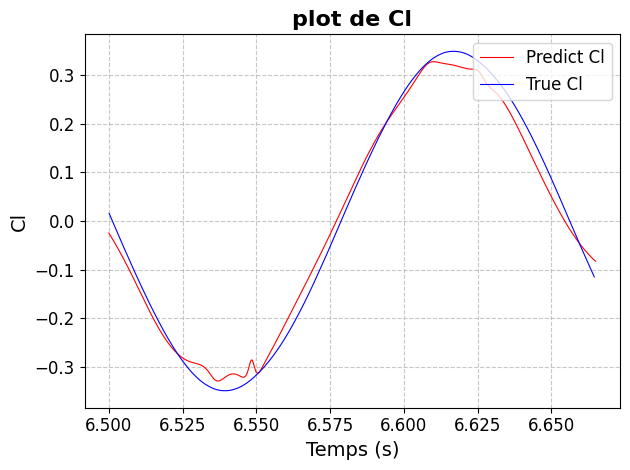

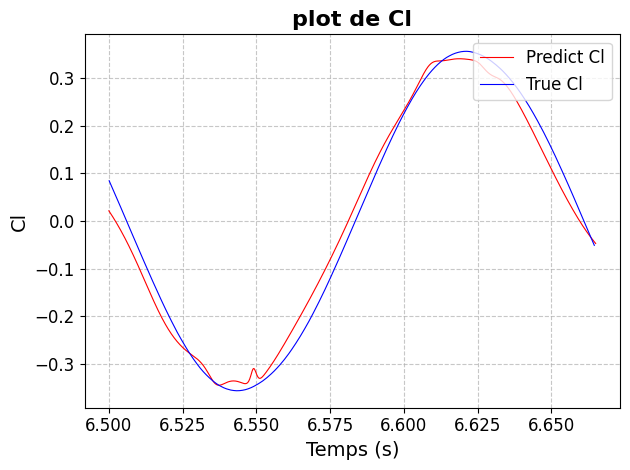

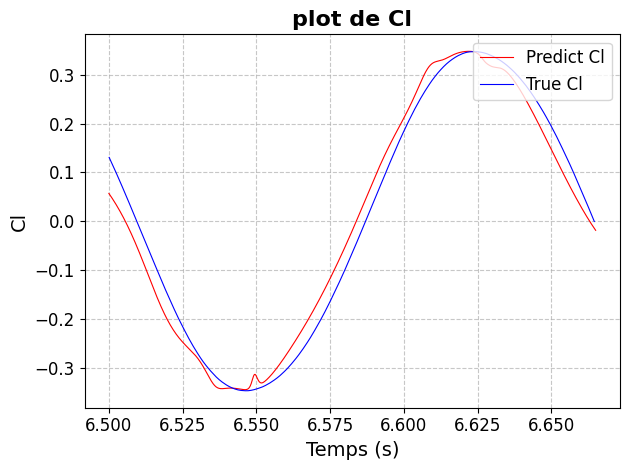

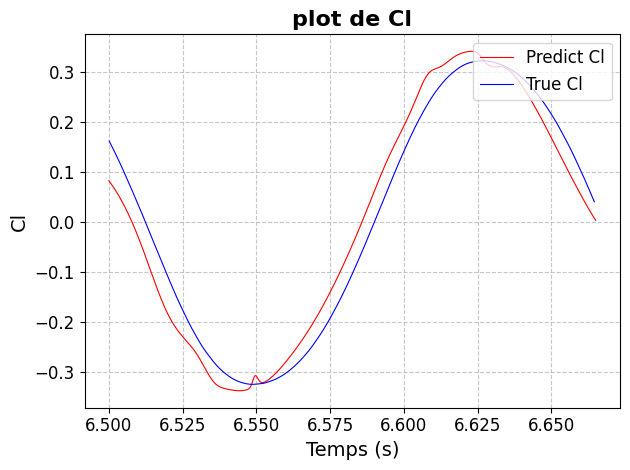

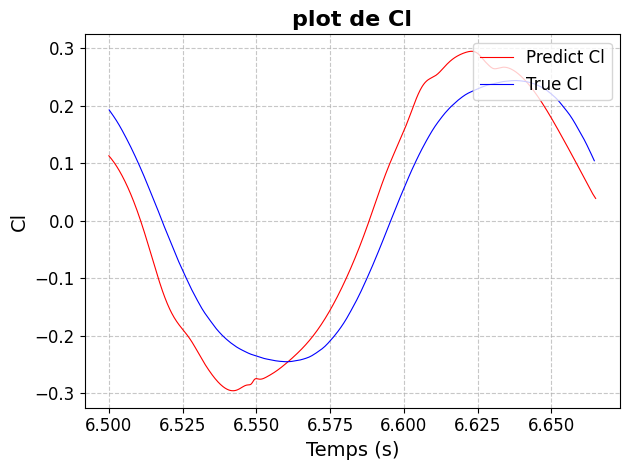

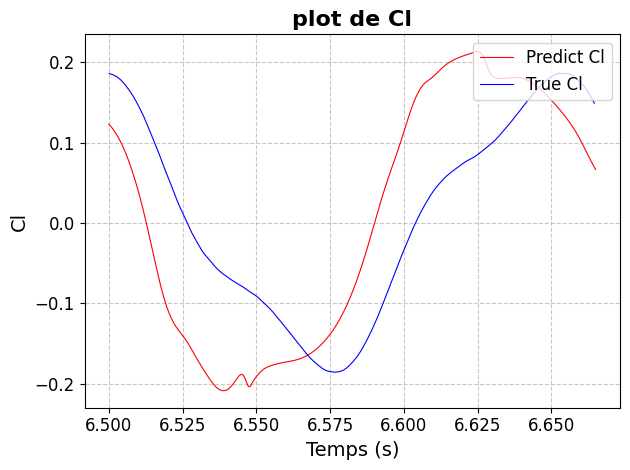

In [12]:
for k in range(len(ya0_L)):
    w0 = torch.pi * (H_L[k]/hyper_param['m'])**0.5
    cl_predict = predict_cl(t, ya0_L[k], w0, model, param_adim, mean_std, nb_disc_theta=1000)
    time, cl_true = true_cl(num=num[k], case=case[k
    
    ], time_init=hyper_param['t_min'], time_max=t_max)
    with torch.no_grad():
        plt.plot(t, cl_predict, color = 'red', label = 'Predict Cl', linewidth=0.8)
        plt.plot(time, cl_true, label = 'True Cl', color='blue', linewidth=0.8)
        plt.title('plot de Cl', fontsize=16, fontweight='bold')  # Titre
        plt.xlabel('Temps (s)', fontsize=14)  # Label de l'axe x
        plt.ylabel('Cl', fontsize=14)  # Label de l'axe y
        plt.legend(loc='upper right', fontsize=12)  # Légende
        plt.grid(alpha=0.7, linestyle= '--')  # Grille avec transparence
        plt.xticks(fontsize=12)  # Taille des ticks de l'axe x
        plt.yticks(fontsize=12)  # Taille des ticks de l'axe y
        plt.tight_layout()  # Ajuste le layout pour éviter le chevauchement
        os.makedirs('results/' + folder_name + f'/H_{H_L[k]}/ya0_{ya0_L[k]:.2e}', exist_ok=True)
        plt.savefig('results/' + folder_name + f'/H_{H_L[k]}/ya0_{ya0_L[k]:.2e}/cl.png')
        plt.show()
    

In [11]:
ya0_L = [
    0.0025,
    0.005,
    0.0075,
    0.0175
]
num_L = [2, 6, 8, 3]

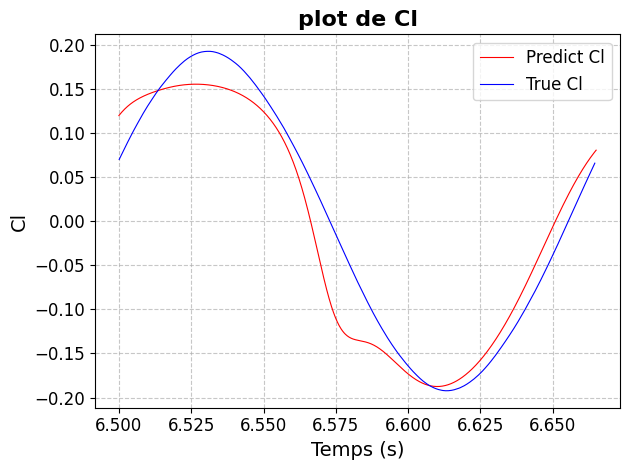

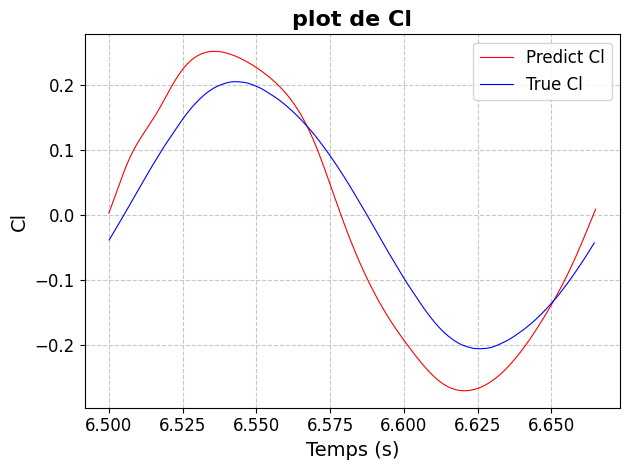

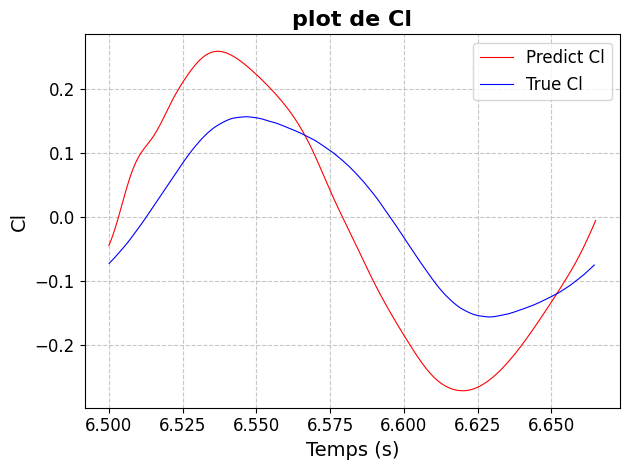

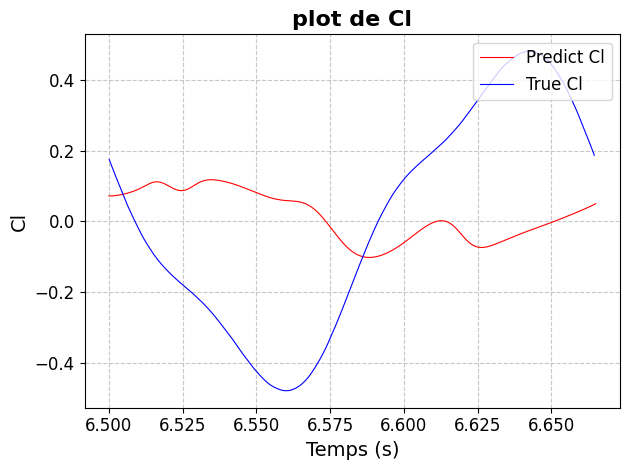

In [13]:
for ya0, num in zip(ya0_L, num_L):
    cl_predict = predict_cl(t, ya0, model, param_adim, mean_std, nb_disc_theta=1000)
    time, cl_true = true_cl(num=num, case=2, time_init=hyper_param['t_min'], time_max=t_max)
    with torch.no_grad():
        plt.plot(t, cl_predict, color = 'red', label = 'Predict Cl', linewidth=0.8)
        plt.plot(time, cl_true, label = 'True Cl', color='blue', linewidth=0.8)
        plt.title('plot de Cl', fontsize=16, fontweight='bold')  # Titre
        plt.xlabel('Temps (s)', fontsize=14)  # Label de l'axe x
        plt.ylabel('Cl', fontsize=14)  # Label de l'axe y
        plt.legend(loc='upper right', fontsize=12)  # Légende
        plt.grid(alpha=0.7, linestyle= '--')  # Grille avec transparence
        plt.xticks(fontsize=12)  # Taille des ticks de l'axe x
        plt.yticks(fontsize=12)  # Taille des ticks de l'axe y
        plt.tight_layout()  # Ajuste le layout pour éviter le chevauchement
        plt.savefig('results/' + folder_name + f'/valid_ya0_{ya0:.2e}/cl.png')
        plt.show()
    

In [12]:
ya0 = 1.75e-2
num = 3

In [ ]:
cl_predict = predict_cl(t, ya0, model, param_adim, mean_std, nb_disc_theta=1000)
time, cl_true = true_cl(num=num, case=2, time_init=hyper_param['t_min'], time_max=hyper_param['t_max'])
with torch.no_grad():
    plt.plot(t, cl_predict, color = 'red', label = 'Predict Cl', linewidth=0.8)
    plt.plot(time, cl_true, label = 'True Cl', color='blue', linewidth=0.8)

NameError: name 'mean_std' is not defined

In [14]:
def piche(t, ya0, model, param_adim, mean_std, r=0.025 / 2, nb_disc_theta=500):
    """
    Args:
        t_ad (torch.tensor): Les temps où on veut Cl
        ya0 (float) : la valeur d'amplitude pour estimer notre Cl
        model (torch.model): le NN qui prédit 
        param_adim (dict): dictionnaire des param d'adim
        mean_std (dict): donne de quoi faire la normalisation Z
        r (float): le rayon du cylindre
        nb_disc_theta(int): sur combien de theta on discrétise

    Returns:
        Cl (torch.float):  les valeurs de pression sur le cylindre
    """
    time_repeat = torch.repeat_interleave(t, repeats=nb_disc_theta)
    d_theta = 2 * torch.pi / nb_disc_theta
    theta_int = torch.linspace(0, 2*torch.pi, nb_disc_theta)
    theta_tot = theta_int.repeat(t.shape[0])
    pressure_tot = P(theta_tot, time_repeat, ya0, model, param_adim, mean_std, r = 0.025 / 2).reshape(t.shape[0], nb_disc_theta) # (t.shape, nb_disc_theta)
    in_sum = pressure_tot * torch.sin(theta_int) * r * d_theta
    portance = - torch.sum(in_sum, dim=1)
    return portance / (0.5 * param_adim['rho'] * param_adim['V']**2 * 2 * r)

In [15]:
theta_int  = torch.ones(1) * 3* torch.pi /2
theta_tot = theta_int.repeat(t.shape[0])
cl_predict2 = P(theta_tot, t, ya0, model, param_adim, mean_std)

NameError: name 'mean_std' is not defined

In [ ]:
cl_predict = piche(t, ya0, model, param_adim, mean_std, nb_disc_theta=1000)
time, cl_true = true_cl(num=num, case=2, time_init=hyper_param['t_min'], time_max=hyper_param['t_max'])
with torch.no_grad():
    plt.plot(t, cl_predict, color = 'blue', label = 'Predict Cl', linewidth=0.8)
    plt.plot(t, cl_predict2, label='pressure')
    plt.plot(time, cl_true, label = 'True Cl', color='red', linewidth=0.8)
    plt.legend()

NameError: name 'mean_std' is not defined

## On essaye d'avoir la différence de phase 

In [17]:
from scipy.signal import hilbert

In [18]:
def find_true_diff_phase(num, case, time_init, time_max, ya0, param_adim):
    """
    Args:
        num (int): Le numéro du modèle
        case (int): Le numéro du case

    Returns:
        None:  plot les courbes de Cl
    """
    df = pd.read_csv(f'results_Cl/model_{num}_case_{case}/Cl.csv', index_col=False)
    df_modified = df[((df.iloc[:, 2] > time_init) & (df.iloc[:, 2] < time_max))]
    time = df_modified.iloc[:, 2].to_numpy()
    cl = df_modified.iloc[:, 1].to_numpy()
    plt.plot(time, cl, label = 'True Cl', color='blue', linewidth=0.8)
    return None

In [19]:
def diff_phase_predict(cl, ya0, hyper_param, t):
    """
    Args:
        cl (numpy.array): cl a différents temps
        ya0 (float) : la valeur d'amplitude pour estimer notre Cl
        hyper_param (dict): les hyperparamètres

    Returns:
        DphaseH (np.array): la valeur de la différence de phase en fonction du temps
        mean (float): la moyenne de différence de phase du signal cl avec la vitesse du cylindre
        rms (float): la std de la différence de phase du signal cl avec la vitesse du cylindre
    """
    w_0 = (hyper_param["H"] / hyper_param["m"]) ** 0.5
    analytic_signal1 = hilbert(cl)
    instantaneous_phase1 = np.unwrap(np.angle(analytic_signal1))
    cylinder_velocity = np.sin(w_0 * t)
    instantaneous_phase2 = np.unwrap(np.angle(hilbert(cylinder_velocity)))

    DphaseH = instantaneous_phase2-instantaneous_phase1
    mean = np.mean(DphaseH)
    rms = np.std(DphaseH)
    return DphaseH, mean, rms

    

In [20]:
cl = predict_cl(t=t,ya0=0.0025, model=model, param_adim=param_adim, mean_std=mean_std, nb_disc_theta=1000).detach().numpy()
DphaseH, mean, rms = diff_phase_predict(cl, ya0, hyper_param, t.detach().numpy())


NameError: name 'mean_std' is not defined

In [21]:
time, cl_true = true_cl(num=2, case=2, time_init=hyper_param['t_min'], time_max=hyper_param['t_max'])
DphaseH2, mean2, rms2 = diff_phase_predict(cl_true, ya0, hyper_param, t=time)

NameError: name 'true_cl' is not defined

In [22]:
mean2

NameError: name 'mean2' is not defined

In [23]:
plt.plot(time, DphaseH2)
plt.plot(t, DphaseH)

NameError: name 'DphaseH2' is not defined

In [24]:
mean

NameError: name 'mean' is not defined

In [25]:
hyper

NameError: name 'hyper' is not defined

In [136]:
cl_piche = np.sin(w_0 * t + 0.3)

/tmp/ipykernel_4236/2140280397.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cl_piche = np.sin(w_0 * t + 0.3)


In [140]:
DphaseH, mean, rms = diff_phase_predict(cl_piche, ya0, hyper_param, t.detach().numpy())

In [141]:
mean

np.float32(-0.29166788)

In [142]:
rms

np.float32(0.01179105)

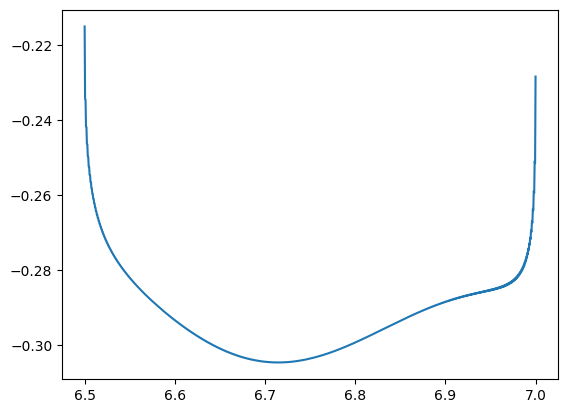

In [143]:
plt.plot(t.detach().numpy(), DphaseH)

In [99]:
rms

np.float32(0.01179105)

In [101]:
mean

np.float32(-0.29166788)

In [113]:
mean

np.float32(0.0)

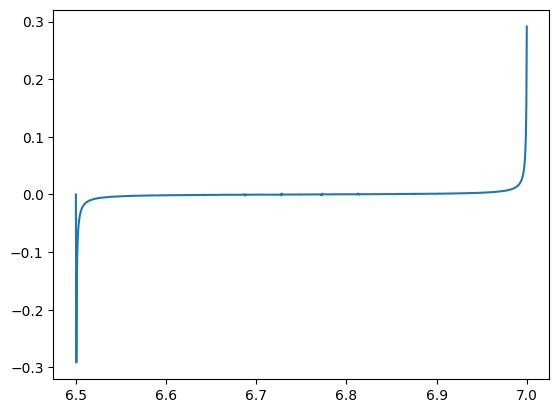

In [112]:
plt.plot(t.detach().numpy(), DphaseH)


In [79]:
mean

np.float32(-6.987098)

In [81]:
rms

np.float32(3.6488428)

In [80]:
mean2

np.float64(-6.622432046880976)

In [82]:
rms2

np.float64(3.7214993615768397)

In [ ]:
cl2 = 

In [ ]:
cl_true = num=2

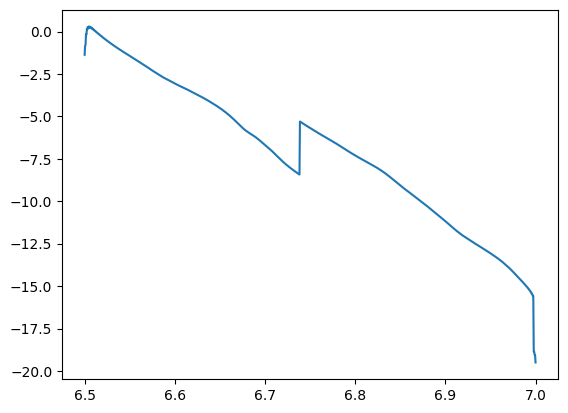

In [18]:
plt.plot(t, DphaseH)

In [19]:
mean

np.float32(-7.0628138)

In [20]:
rms

np.float32(4.174604)

In [93]:
w_0 = (hyper_param["H"] / hyper_param["m"]) ** 0.5
analytic_signal1 = hilbert(cl.detach().numpy())
instantaneous_phase1 = np.unwrap(np.angle(analytic_signal1))

cylinder_velocity = - ya0 * w_0 * np.sin(w_0 * t.detach().numpy())
instantaneous_phase2 = np.unwrap(np.angle(cylinder_velocity))

DphaseH = instantaneous_phase2-instantaneous_phase1
mean = np.mean(DphaseH)
rms = np.std(DphaseH)

In [94]:
mean

np.float32(-7.060839)

In [96]:
rms

np.float32(4.164276)

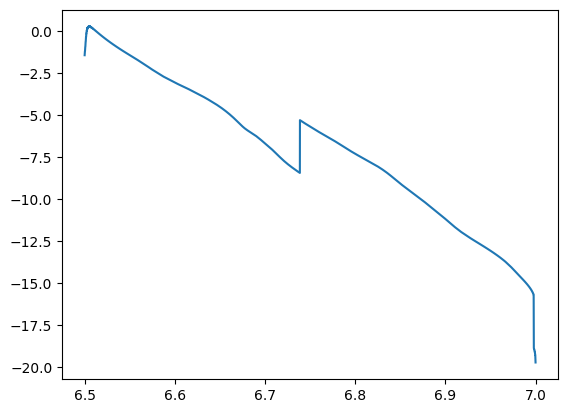

In [ ]:
plt.plot(t, DphaseH)

In [88]:
rms

np.float32(4.0255566)

In [80]:
w_0

12.121203194360733